In [2]:
import numpy as np
import pickle
import csv
import torch
from torch.linalg import inv, eig, pinv
from matplotlib import pyplot as plt
from tools import whiten, adap_whitening, adap_whitening_2
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from datetime import datetime
import sklearn
import pickle
from scipy.ndimage import gaussian_filter1d
from tools import load, split, estimate_derivative, plot_two_intervals

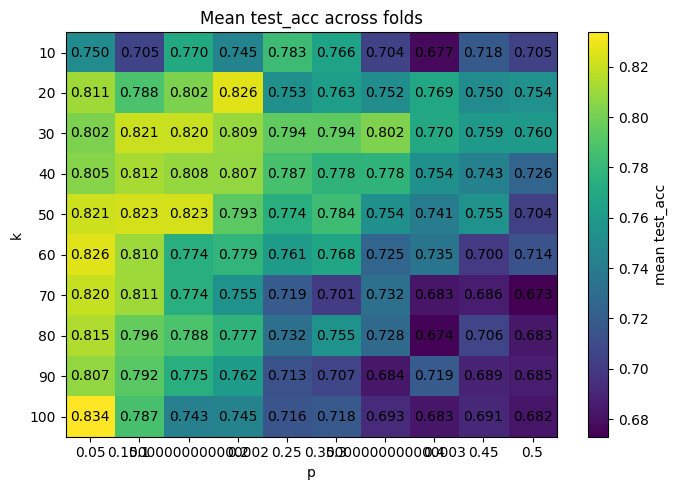

In [3]:
# --- load ---
with open("data/gridsearch_blank.pkl", "rb") as f:
    d = pickle.load(f)

k  = np.asarray(d["params"]["k"])
p  = np.asarray(d["params"]["p"])
ta = np.asarray(d["results"]["test_acc"], dtype=float)

# --- group by (k, p) and compute means across folds (no pandas) ---
# sort by (k, p)
idx = np.lexsort((p, k))       # primary k, then p
ks, ps, tas = k[idx], p[idx], ta[idx]

# find group starts where (k, p) changes
chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
starts = np.r_[0, np.flatnonzero(chg) + 1]

# sums and counts per group → means
sums = np.add.reduceat(tas, starts)
counts = np.diff(np.r_[starts, tas.size])
means = sums / counts

gk = ks[starts]   # k per group
gp = ps[starts]   # p per group

# --- put into a 2D grid (rows=k, cols=p) ---
ku = np.unique(k)
pu = np.unique(p)
grid = np.full((ku.size, pu.size), np.nan)

ki = np.searchsorted(ku, gk)
pi = np.searchsorted(pu, gp)
grid[ki, pi] = means

# --- plot ---
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(grid, aspect="auto")  # default colormap
ax.set_xticks(np.arange(pu.size)); ax.set_xticklabels(pu)
ax.set_yticks(np.arange(ku.size)); ax.set_yticklabels(ku)
ax.set_xlabel("p")
ax.set_ylabel("k")
ax.set_title("Mean test_acc across folds")

# annotate cells
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if np.isfinite(grid[i, j]):
            ax.text(j, i, f"{grid[i, j]:.3f}", ha="center", va="center")

fig.colorbar(im, ax=ax, label="mean test_acc")
plt.tight_layout()
plt.show()

In [4]:
k       = np.asarray(d["params"]["k"])
p       = np.asarray(d["params"]["p"])
n_fold  = np.asarray(d["params"]["n_fold"])
testacc = np.asarray(d["results"]["test_acc"], dtype=float)

# --- group by (k, p) and compute mean across folds ---
idx = np.lexsort((p, k))           # sort by k, then p
ks, ps, tas = k[idx], p[idx], testacc[idx]

chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
starts = np.r_[0, np.flatnonzero(chg) + 1]

sums   = np.add.reduceat(tas, starts)
counts = np.diff(np.r_[starts, tas.size])
means  = sums / counts

gk = ks[starts]
gp = ps[starts]

# --- pick best group by highest mean ---
best_group = int(np.nanargmax(means))
best_k = gk[best_group]
best_p = gp[best_group]

# all folds at those params
mask = (k == best_k) & (p == best_p)
best_vals = testacc[mask]
best_folds = n_fold[mask]

# best single-fold at those params
best_single_idx = int(np.nanargmax(best_vals))
best_n_fold = best_folds[best_single_idx]

# --- print in requested style (adapted: p instead of N_pot, no t_delay available) ---
print(
    f"Best params → k={best_k}, p={best_p}\n"
    f"Highest mean test accuracy: {np.nanmean(best_vals):.4f} ± {np.nanstd(best_vals):.4f} (n={best_vals.size})\n"
    f"Highest single-fold test accuracy at those params: {np.nanmax(best_vals):.4f}, n_fold={best_n_fold}"
)

Best params → k=100, p=0.05
Highest mean test accuracy: 0.8337 ± 0.0620 (n=20)
Highest single-fold test accuracy at those params: 0.9200, n_fold=3


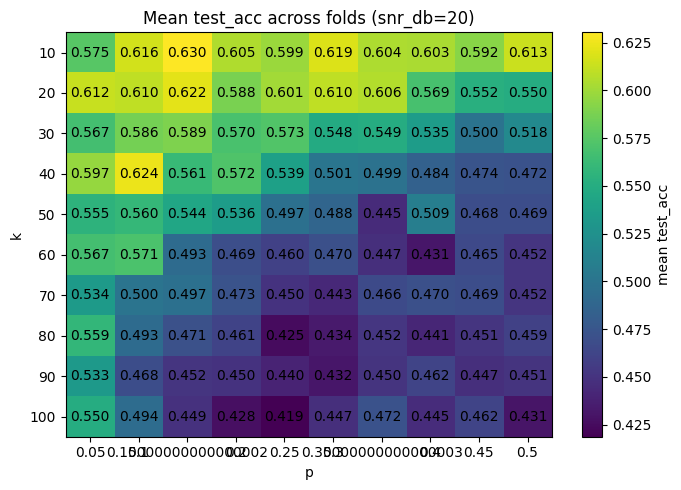

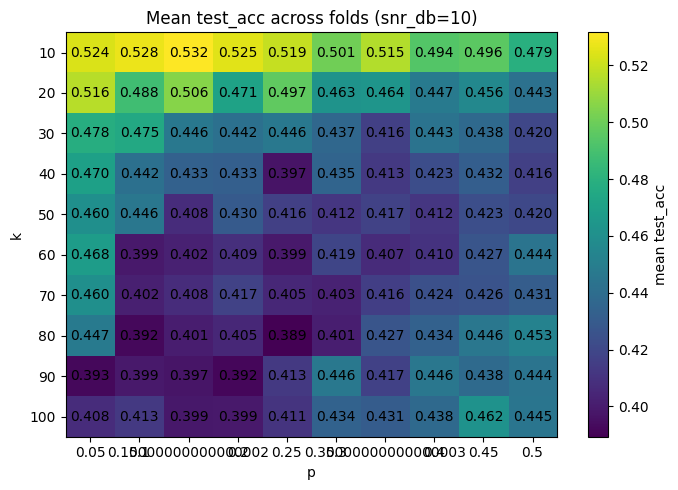

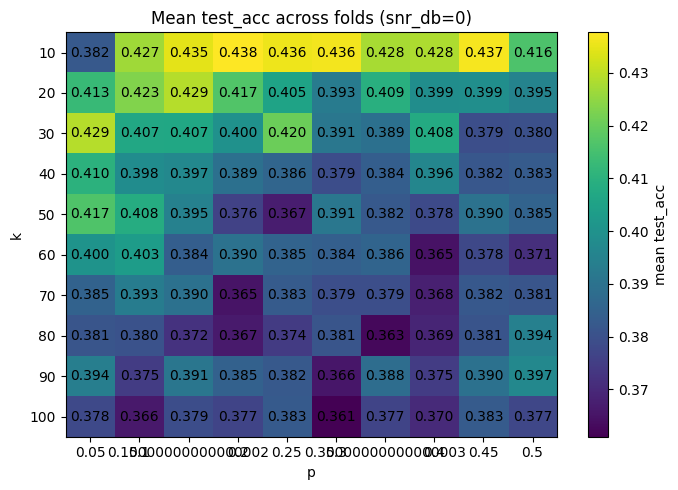

In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# --- load ---
with open("data/gridsearch_whitenoise.pkl", "rb") as f:   # <-- adjust path/name if needed
    d = pickle.load(f)

k    = np.asarray(d["params"]["k"])
p    = np.asarray(d["params"]["p"])
snr  = np.asarray(d["params"]["snr_db"])
ta   = np.asarray(d["results"]["test_acc"], dtype=float)

def plot_grid_for_snr(snr_value):
    # filter for a single SNR
    m = (snr == snr_value)
    if not np.any(m):
        print(f"No entries found for snr_db={snr_value}")
        return

    ks, ps, tas = k[m], p[m], ta[m]

    # --- group by (k, p) and compute means across folds (no pandas) ---
    # sort by (k, p)  (primary k, then p)
    idx = np.lexsort((ps, ks))
    ks, ps, tas = ks[idx], ps[idx], tas[idx]

    # find group starts where (k, p) changes
    chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
    starts = np.r_[0, np.flatnonzero(chg) + 1]

    # sums and counts per group → means
    sums = np.add.reduceat(tas, starts)
    counts = np.diff(np.r_[starts, tas.size])
    means = sums / counts

    gk = ks[starts]   # k per group
    gp = ps[starts]   # p per group

    # --- put into a 2D grid (rows=k, cols=p) ---
    ku = np.unique(ks)
    pu = np.unique(ps)
    grid = np.full((ku.size, pu.size), np.nan)

    ki = np.searchsorted(ku, gk)
    pi = np.searchsorted(pu, gp)
    grid[ki, pi] = means

    # --- plot (one figure per SNR) ---
    fig, ax = plt.subplots(figsize=(7, 5))
    im = ax.imshow(grid, aspect="auto")  # default colormap
    ax.set_xticks(np.arange(pu.size)); ax.set_xticklabels(pu)
    ax.set_yticks(np.arange(ku.size)); ax.set_yticklabels(ku)
    ax.set_xlabel("p")
    ax.set_ylabel("k")
    ax.set_title(f"Mean test_acc across folds (snr_db={snr_value})")

    # annotate cells
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if np.isfinite(grid[i, j]):
                ax.text(j, i, f"{grid[i, j]:.3f}", ha="center", va="center")

    fig.colorbar(im, ax=ax, label="mean test_acc")
    plt.tight_layout()
    plt.show()

# --- make the three plots ---
for s in (20, 10, 0):
    plot_grid_for_snr(s)


In [7]:
import numpy as np

k        = np.asarray(d["params"]["k"])
p        = np.asarray(d["params"]["p"])
n_fold   = np.asarray(d["params"]["n_fold"])
snr_db   = np.asarray(d["params"]["snr_db"])
testacc  = np.asarray(d["results"]["test_acc"], dtype=float)

# prefer [20, 10, 0] if present; otherwise enumerate whatever is in the data
preferred_order = [20, 10, 0]
snr_values = [s for s in preferred_order if np.any(snr_db == s)]
if not snr_values:
    snr_values = list(np.unique(snr_db))

for s in snr_values:
    m = (snr_db == s)
    if not np.any(m):
        continue

    km, pm, tam, fm = k[m], p[m], testacc[m], n_fold[m]

    # --- group by (k, p) and compute mean across folds (within this SNR) ---
    idx = np.lexsort((pm, km))  # sort by k, then p
    ks, ps, tas = km[idx], pm[idx], tam[idx]

    chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
    starts = np.r_[0, np.flatnonzero(chg) + 1]

    sums   = np.add.reduceat(tas, starts)
    counts = np.diff(np.r_[starts, tas.size])
    means  = sums / counts

    gk = ks[starts]
    gp = ps[starts]

    # --- pick best group by highest mean ---
    best_group = int(np.nanargmax(means))
    best_k = gk[best_group]
    best_p = gp[best_group]

    # all folds at those params (still within this SNR)
    mask_bp = (km == best_k) & (pm == best_p)
    best_vals  = tam[mask_bp]
    best_folds = fm[mask_bp]

    # best single-fold at those params
    best_single_idx = int(np.nanargmax(best_vals))
    best_n_fold = best_folds[best_single_idx]

    print(
        f"[snr_db={s}] Best params → k={best_k}, p={best_p}\n"
        f"  Highest mean test accuracy: {np.nanmean(best_vals):.4f} ± {np.nanstd(best_vals):.4f} (n={best_vals.size})\n"
        f"  Highest single-fold test accuracy at those params: {np.nanmax(best_vals):.4f}, n_fold={best_n_fold}\n"
    )


[snr_db=20] Best params → k=10, p=0.15000000000000002
  Highest mean test accuracy: 0.6303 ± 0.0661 (n=20)
  Highest single-fold test accuracy at those params: 0.7600, n_fold=3

[snr_db=10] Best params → k=10, p=0.15000000000000002
  Highest mean test accuracy: 0.5317 ± 0.0640 (n=20)
  Highest single-fold test accuracy at those params: 0.6467, n_fold=5

[snr_db=0] Best params → k=10, p=0.2
  Highest mean test accuracy: 0.4377 ± 0.0348 (n=20)
  Highest single-fold test accuracy at those params: 0.4933, n_fold=1

